# Imports

In [1]:
import os
import pandas

from bumps.cli import load_model, load_best
from molgroups.support import molstat

# Variables

Variables to set the storage folder for the fit, the base name of the runfile, and the global optimizer. Further the
number of burn and production stepst for the MCMC are set. The run flag determines whether the refl1d MCMC is run, or
just a data analysis on a previous fit is performed.

Steps (and burn) are intentionally small in this example to reduce file sizes.

In [2]:
setupdir = os.getcwd()
store = "fit"
runfile = "run"
fitsource = "refl1d"

if not os.path.isdir(store):
    os.mkdir(store)

run = True
burn = 4000
steps = 50


# Example Fit

The content of the following cell is written out to the runfile of the fit 'tblm.py'.

In [3]:
%%writefile run.py
## === Import section ===
import numpy as np
from molgroups import mol
from molgroups import components as cmp
import lipids
from refl1d.names import load4, Parameter, SLD, Slab, Stack, Experiment, FitProblem
from refl1d.flayer import FunctionalProfile

## === Film structure definition section ===

### Bilayer profile definition function

def bilayer(z, sigma, bulknsld, global_rough, rho_substrate,nf_tether, mult_tether, l_tether, l_lipid1, l_lipid2, vf_bilayer):
    """ Generic tethered bilayer """

    # Scale all SLDs from Refl1D units (1e-6 Ang^-2) to molgroups units (Ang^-2)
    bulknsld = bulknsld * 1e-6
    rho_substrate = rho_substrate * 1e-6

    blm.fnSet(sigma=sigma, bulknsld=bulknsld, global_rough=global_rough, rho_substrate=rho_substrate,
              nf_tether=nf_tether, mult_tether=mult_tether, l_tether=l_tether, l_lipid1=l_lipid1, l_lipid2=l_lipid2,
              vf_bilayer=vf_bilayer)

    # Calculate scattering properties of volume occupied by bilayer
    normarea, area, nsl = blm.fnWriteProfile(z)

    # Fill in the remaining volume with buffer of appropriate nSLD
    nsld = nsl / (normarea * np.gradient(z)) + (1.0 - area / normarea) * bulknsld

    # export objects for post analysis, needs to be from this function
    problem.moldat = blm.fnWriteGroup2Dict({}, 'bilayer', np.arange(dimension) * stepsize)
    problem.results = blm.fnWriteResults2Dict({}, 'bilayer')

    # Return nSLD profile in Refl1D units
    return nsld * 1e6

# Define bilayer parameters
vf_bilayer = Parameter(name='volume fraction bilayer', value=0.9).range(0.0, 1.0)
l_lipid1 = Parameter(name='inner acyl chain thickness', value=10.0).range(8, 30)
l_lipid2 = Parameter(name='outer acyl chain thickness', value=10.0).range(8, 16)
sigma = Parameter(name='bilayer roughness', value=5).range(2, 9)
global_rough = Parameter(name ='substrate roughness', value=5).range(2, 9)
d_oxide = Parameter(name='silicon oxide layer thickness', value=10).range(5, 30)
d_Cr =  Parameter(name='chromium layer thickness', value=40).range(10, 150)
d_gold =  Parameter(name='gold layer thickness', value=100).range(150, 250) #thickness of gold
rough_cr_au =  Parameter(name='gold chromium roughness', value=10).range(2, 24.0) # roughness of Cr/Au interface
nf_tether =  Parameter(name='number fraction tether', value=0.7).range(0.2, 1.0) # number fraction of tether molecules in inner leaflet
mult_tether =  Parameter(name='bME to tether ratio', value=2).range(0.1, 4) #ratio of bME to tether molecules at surface
l_tether =  Parameter(name='tether length', value=10).range(3, 18) #distance from substrate to inner headgroup/acyl chain interface

### Define bilayer object
blm = mol.tBLM(tether=lipids.HC18SAc, filler=cmp.bmeSAc, lipids=[lipids.POPC], lipid_nf=[1.0])        # required to subtract the bilayer length in layer_tiox definition; only really necessary if using "global blm" in bilayer function

### Define molgroups space.
dimension=300       # Number of steps

# Length of steps. Also sets calculation resolution, and determines speed of calculation
stepsize=0.5

## === Stack ===
##
## First, we create a 'material' for each bulk layer, which has an real and imaginary
## scattering length density, stored in a Refl1d object called 'SLD'
d2o = SLD(name='d2o', rho=6.3000, irho=0.0000)
h2o = SLD(name='h2o', rho=-0.56, irho=0.0000)
siox = SLD(name='siox', rho=4.1000, irho=0.0000)
silicon = SLD(name='silicon', rho=2.0690, irho=0.0000)
cr = SLD(name='chromium', rho=2.7, irho=0.0)
gold = SLD(name='gold', rho=4.4, irho=0.0) #iro is the absorption of neutrons, should be 0

## Then bulk layers are created, each with its own 'material'.  If you want to force
## two layers to always match SLD you can use the same material in multiple layers.
## The roughnesses of each layer are set to zero to begin with:

layer_d2o = Slab(material=d2o, thickness=0.0000, interface=5.0000)
layer_h2o = Slab(material=h2o, thickness=0.0000, interface=5.0000)
layer_siox = Slab(material=siox, thickness=d_oxide, interface=global_rough)
layer_silicon = Slab(material=silicon, thickness=0.0000, interface=global_rough)
layer_cr = Slab(material=cr, thickness=d_Cr, interface=rough_cr_au)
layer_gold = Slab(material=gold, thickness=d_gold - (blm.substrate.z + 0.5 * blm.substrate.length), interface=0.0000)

## Use the bilayer definition function to generate the bilayer SLD profile, passing in the relevant parameters.
## Note that substrate and bulk SLDs are linked to their respective materials.
mollayer = FunctionalProfile(dimension*stepsize, 0, profile=bilayer, sigma=sigma, bulknsld=d2o.rho,
                             global_rough=global_rough, rho_substrate=gold.rho, nf_tether = nf_tether,
                             mult_tether = mult_tether, l_tether = l_tether, l_lipid1=l_lipid1, l_lipid2=l_lipid2,
                             vf_bilayer=vf_bilayer)

mollayerh = FunctionalProfile(dimension*stepsize, 0, profile=bilayer, sigma=sigma, bulknsld=h2o.rho,
                              global_rough=global_rough, rho_substrate=gold.rho, nf_tether = nf_tether,
                              mult_tether = mult_tether, l_tether = l_tether, l_lipid1=l_lipid1, l_lipid2=l_lipid2,
                              vf_bilayer=vf_bilayer)

## Stack the layers into individual samples, using common layer objects for layers that are unchanged between samples
## As a convention, always build the sample from the substrate up. If the neutron beam is incident from the substrate side,
## set back_reflectivity = True in the probe definition later.

sample = layer_silicon | layer_siox | layer_cr | layer_gold | mollayer | layer_d2o
sampleh = layer_silicon | layer_siox | layer_cr | layer_gold | mollayerh | layer_h2o

## Set sample parameter ranges and constraints between layer properties, if these are not set using parameters previously

# nSLD parameters
d2o.rho.range(5.3000, 6.5000)
h2o.rho.range(-0.6, 0.6)
siox.rho.range(3.1000, 5.1000)
cr.rho.range(2.7000, 4.0000)
gold.rho.range(4.2000, 4.8000)

## === Data files ===
probe = load4('os046_4column.refl', back_reflectivity=True)
probeh = load4('os047_4column.refl', back_reflectivity=True)

# Background parameter
# probe.background.value = 0.0000
probe.background.range(-1e-7, 1e-5)
probeh.background.range(-1e-7, 1e-5)
probe.intensity.range(0.9, 1.05)
probeh.intensity = probe.intensity
probe.theta_offset.range(-0.015, 0.015)
probeh.theta_offset = probe.theta_offset
probe.sample_broadening.range(-0.005, 0.02)
probeh.sample_broadening = probe.sample_broadening

# Define critical edge oversampling for samples that require it (typically D2O only)
probe.critical_edge(substrate=silicon, surface=d2o)

## === Problem definition ===
## a model object consists of a sample and a probe,

## step = True corresponds to a calculation of the reflectivity from an actual profile
## with microslabbed interfaces.  When step = False, the Nevot-Croce
## approximation is used to account for roughness.  This approximation speeds up
## the calculation tremendously, and is reasonably accuarate as long as the
## roughness is much less than the layer thickness
step = False

model = Experiment(sample=sample, probe=probe, dz=stepsize, step_interfaces = step)
modelh = Experiment(sample=sampleh, probe=probeh, dz=stepsize, step_interfaces = step)
problem = FitProblem([model, modelh])

Writing run.py


# Running the fit

The following runs the fit using rs.py. It can also be run manually from the command line using, for example:
> refl1d_cli.py tblm.py --fit=dream --init=lhs --parallel --store=fit --burn=16000 --steps=500

No file: /Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/data_fitting/refl1d/tBLM/fit/run.py
No state to reload.
# steps: 50, # draws: 11000
step 1 cost 43.17(10)
                background os046_4column .....|.... 5.46172e-06 in (-1e-07,1e-05)
                 intensity os046_4column ....|.....   0.970386 in (0.9,1.05)
         sample_broadening os046_4column .....|....   0.008922 in (-0.005,0.02)
              theta_offset os046_4column .....|.... 0.00130271 in (-0.015,0.015)
                     substrate roughness .........|    8.98974 in (2,9)
                                siox rho |.........    3.10029 in (3.1,5.1)
           silicon oxide layer thickness |.........     5.0528 in (5,30)
                 gold chromium roughness .........|    23.1262 in (2,24)
                            chromium rho ........|.    3.77964 in (2.7,4)
                chromium layer thickness ..|.......    43.2313 in (10,150)
                          

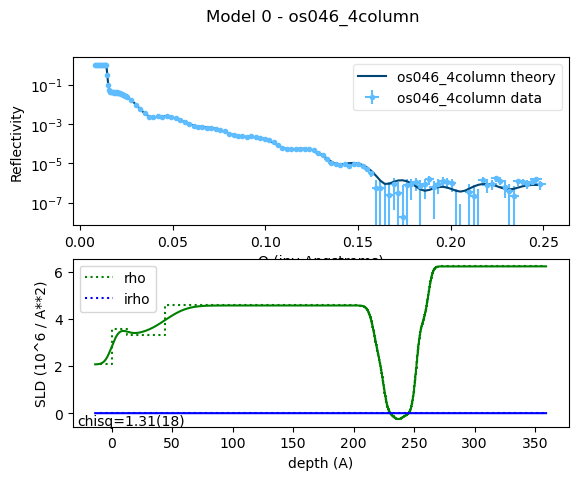

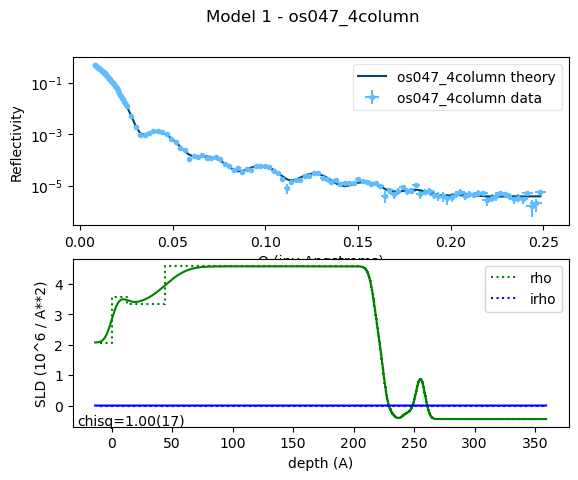

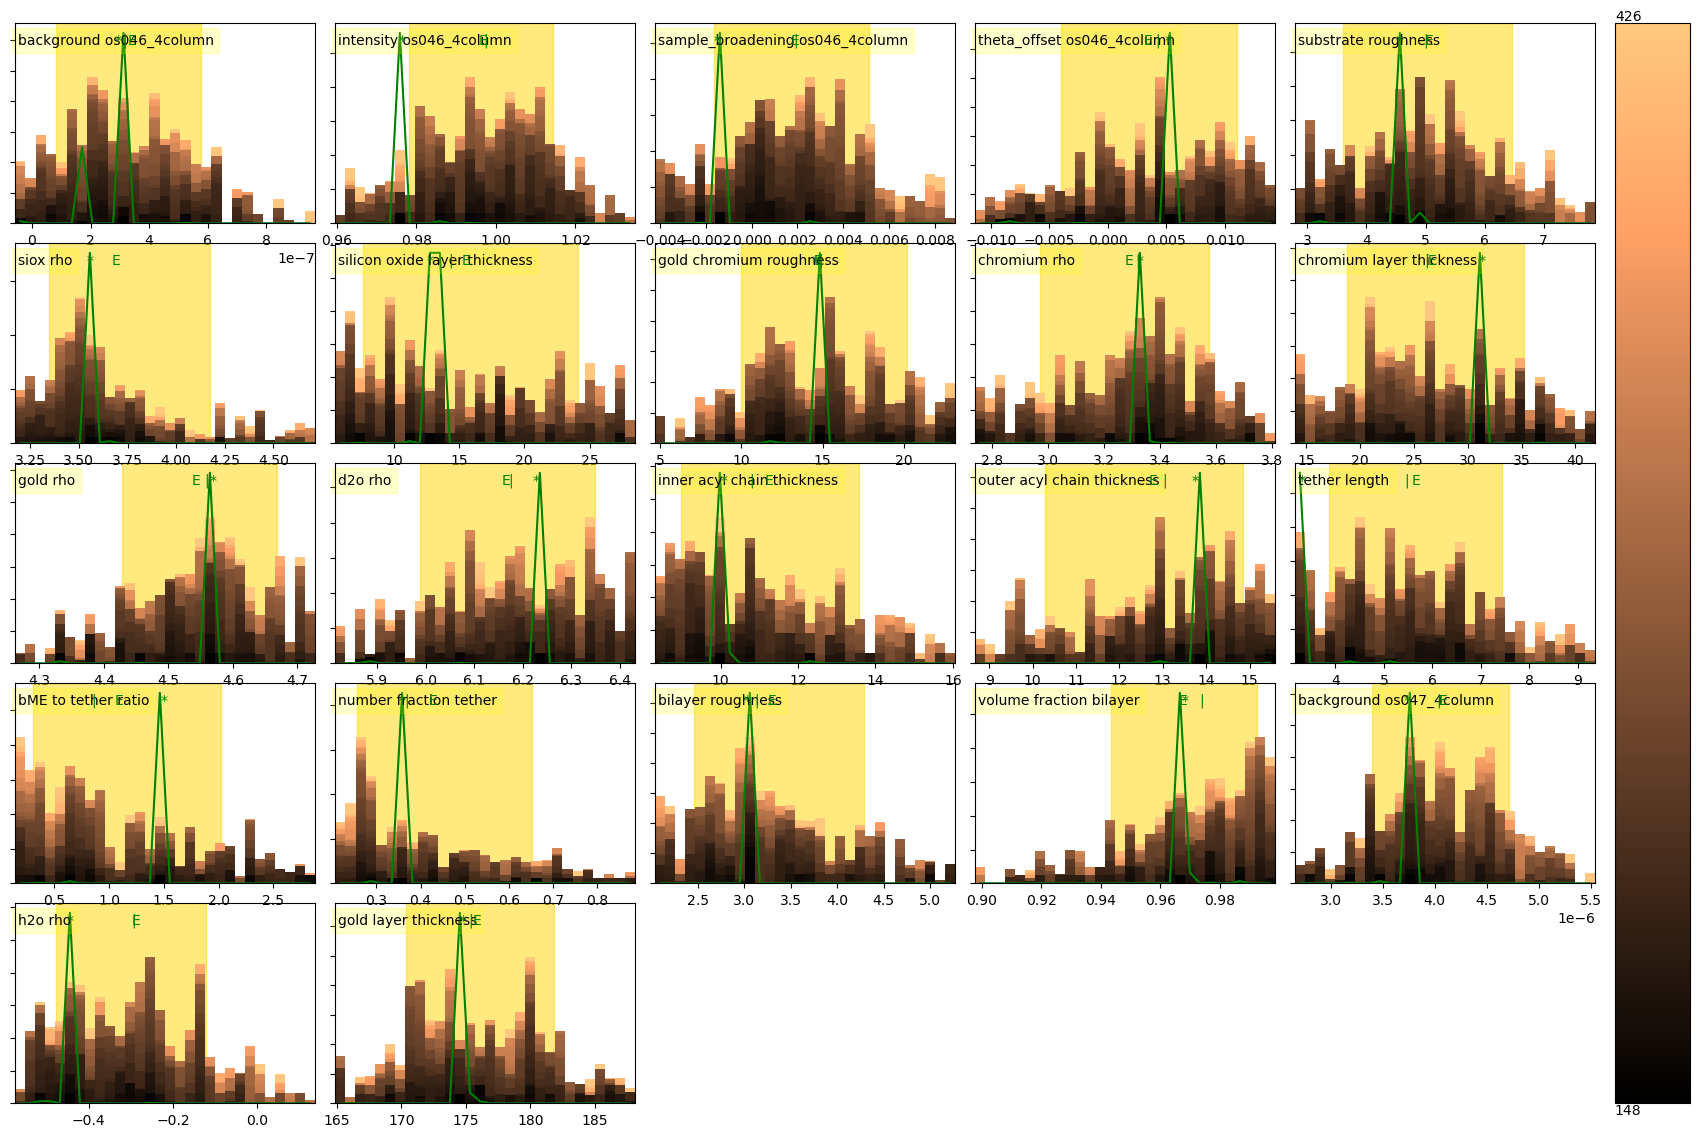

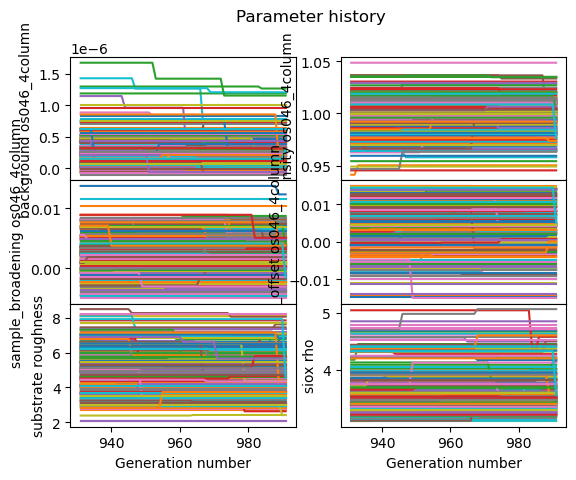

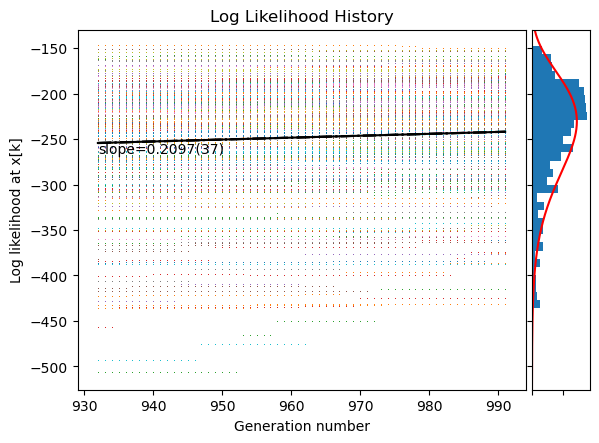

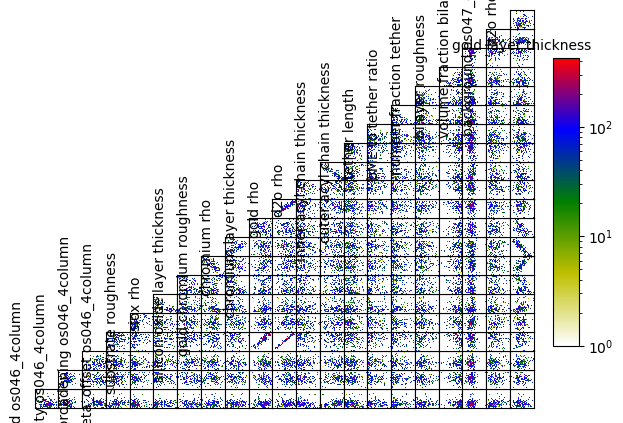

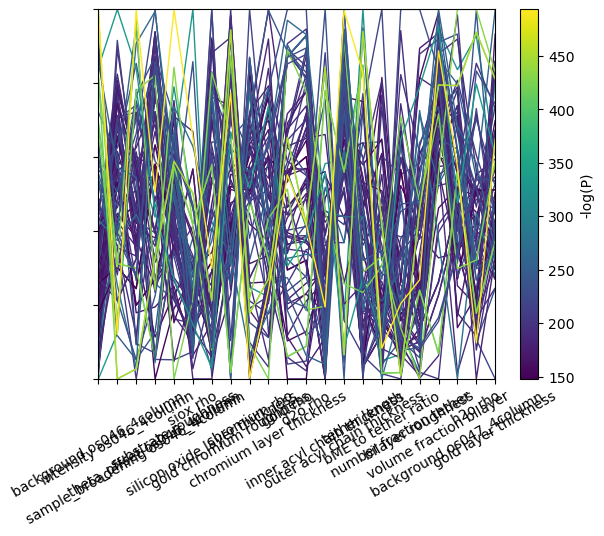

In [4]:
if run:
    if os.path.isfile(store + "/sErr.dat"):
        os.remove(store + "/sErr.dat")
    if os.path.isfile(store + "/isErr.dat"):
        os.remove(store + "/isErr.dat")
    if os.path.isfile(store + "/StatDataPython.dat"):
        os.remove(store + "/StatDataPython.dat")

fit_object = molstat.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=None,
    problem=None
)

if run:
    fit_object.Interactor.fnRunMCMC(burn, steps, batch=False)

print('Restore fit from: ', os.path.join(os.getcwd(), store, runfile))
fit_object.fnRestoreFit()

# Analysis

Statistical analysis of fit results.

Median values, 68% confidence limits (-1, 94%: -2, etc.), and fit intervals for all fit parameters.

In [5]:
sparse = 0.05
fit_object.fnAnalyzeStatFile(fConfidence=-1, sparse=sparse)

No StatDataPython.dat.
Recreate statistical data from sErr.dat.
Analysis of MCMC fit ...
Number of iterations: 635

Fit Parameters:


,origin,name,vis,lower limit,upper limit,lower percentile,median percentile,upper percentile,interval lower,interval upper,confidence
0,fit,background_os046_4column,[+| ],-1.000000e-07,0.00001,6.525413e-08,3.099693e-07,5.566441e-07,-2.447152e-07,2.466748e-07,0.682689
1,fit,intensity_os046_4column,[ |- | ],9.000000e-01,1.05000,9.782448e-01,9.966378e-01,1.014040e+00,-1.839292e-02,1.740200e-02,0.682689
2,fit,sample_broadening_os046_4column,[ | -| ],-5.000000e-03,0.02000,-2.179107e-03,1.951320e-03,5.100195e-03,-4.130427e-03,3.148875e-03,0.682689
3,fit,theta_offset_os046_4column,[ | - | ],-1.500000e-02,0.01500,-4.021800e-03,4.354349e-03,1.105089e-02,-8.376149e-03,6.696544e-03,0.682689
4,fit,substrate_roughness,[ | - | ],2.000000e+00,9.00000,3.452995e+00,4.970919e+00,6.617241e+00,-1.517924e+00,1.646322e+00,0.682689
...,...,...,...,...,...,...,...,...,...,...,...
64,bilayer,water in inner headgroups,,NaN,NaN,-2.282132e-02,4.041760e-02,1.043923e-01,-6.323892e-02,6.397467e-02,0.682689
65,bilayer,water in hydrocarbons,,NaN,NaN,2.836142e-02,4.583061e-02,6.577604e-02,-1.746919e-02,1.994544e-02,0.682689
66,bilayer,water in outer headgroups,,NaN,NaN,4.414240e-01,4.946189e-01,5.727953e-01,-5.319491e-02,7.817642e-02,0.682689
67,bilayer,thickness_tether,,NaN,NaN,5.814792e+00,7.006171e+00,8.551002e+00,-1.191379e+00,1.544831e+00,0.682689


Create bilayer statistics from above parameter statistics. Results are saved to bilayerplotdata.dat.

In [6]:
fit_object.fnProfilesStat()
pandas.DataFrame(fit_object.diStatResults['Molgroups'].keys(), columns=['molecular groups'])

,molecular groups
0,bilayer.bME
1,bilayer.defect_hg
2,bilayer.defect_hc
3,bilayer.headgroup1_1
4,bilayer.headgroup1_1.carbonyl_glycerol
5,bilayer.headgroup1_1.choline
6,bilayer.headgroup1_1.phosphate
7,bilayer.headgroup2_1
8,bilayer.headgroup2_1.carbonyl_glycerol
9,bilayer.headgroup2_1.choline


Plot selected data from bilayerplotdata.dat

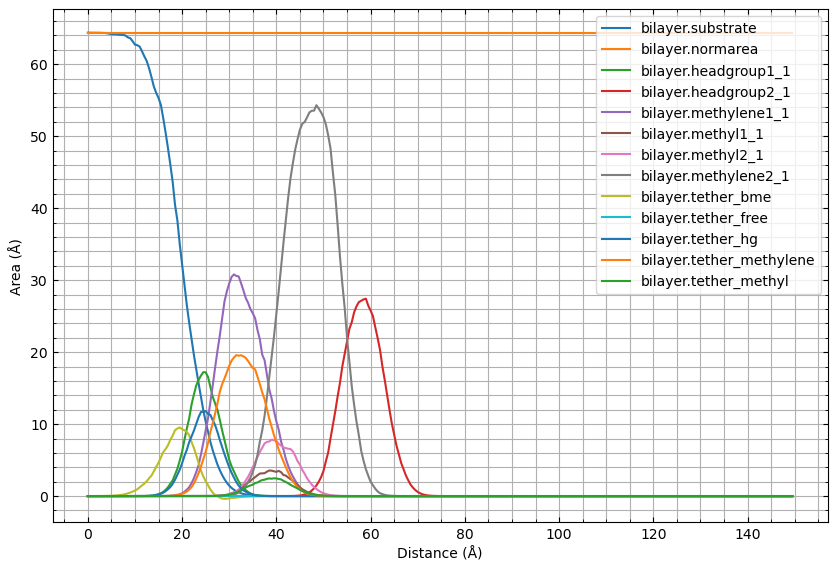

In [7]:
import matplotlib.pyplot as plt

median=['bilayer.substrate', 'bilayer.normarea', 'bilayer.headgroup1_1', 'bilayer.headgroup2_1', 'bilayer.methylene1_1', 'bilayer.methyl1_1', 'bilayer.methyl2_1', 'bilayer.methylene2_1', 'bilayer.tether_bme', 'bilayer.tether_free', 'bilayer.tether_hg', 'bilayer.tether_methylene', 'bilayer.tether_methyl']
uncertainties=[]

fig, ax = plt.subplots()
for gp in median:
    zaxis = fit_object.diStatResults['Molgroups'][gp]['zaxis']
    area = fit_object.diStatResults['Molgroups'][gp]['median area']
    ax.plot(zaxis, area, label=gp)
    if gp in uncertainties:
        msigma = fit_object.diStatResults['Molgroups'][gp]['msigma area']
        psigma = fit_object.diStatResults['Molgroups'][gp]['psigma area']
        ax.fill_between(zaxis, msigma, psigma, alpha=0.3)

ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("Area (Å)")
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
#plt.xlim(0, 100)
#plt.xticks(numpy.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
fig.patch.set_facecolor('white')
ax.figure.set_size_inches(10, 6.66)
plt.savefig(store + "/cvo", facecolor="white")
plt.show()

Compute statistical properties of interest with 68% confidence limits, such as the area per lipid of the outer lipid
leaflet.

A simple way to show output files from the fit. Publication-ready graphs can be created from the data in the storage
directory or using fit_object:

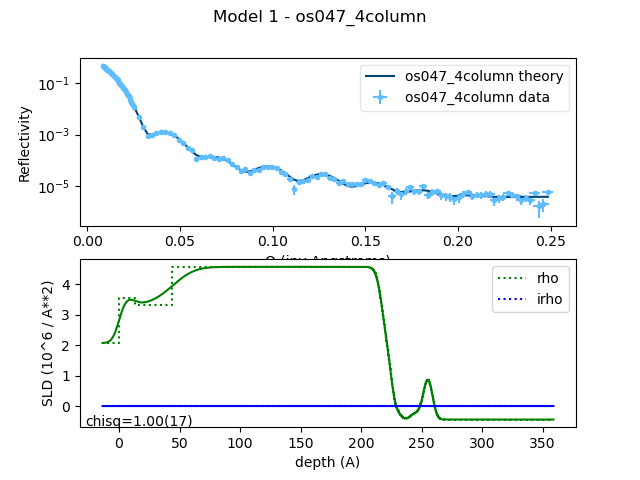

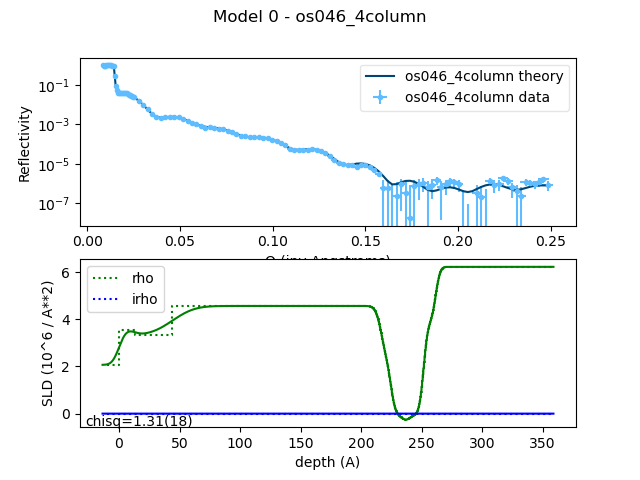

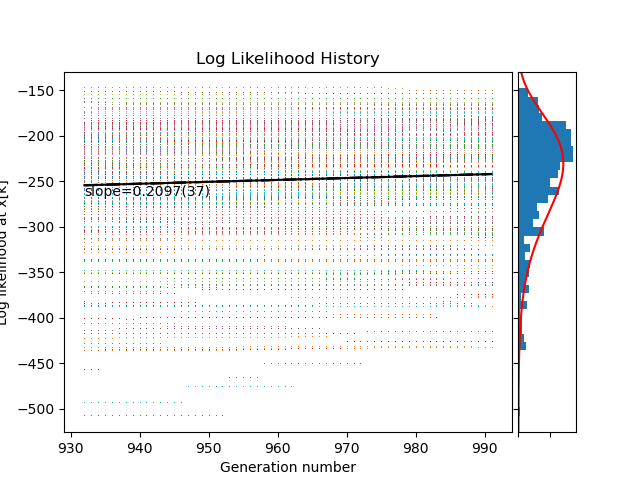

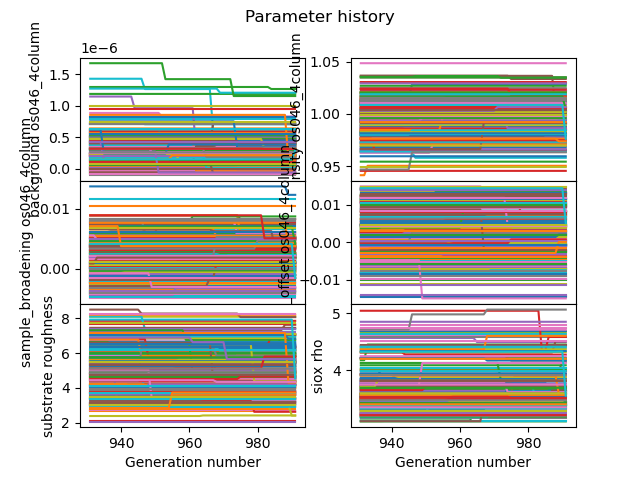

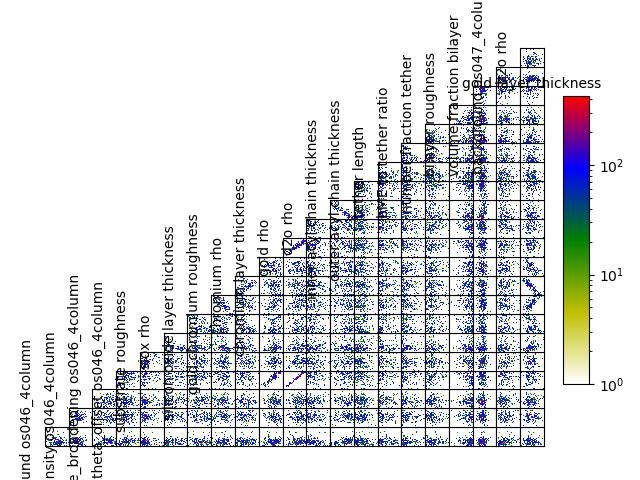

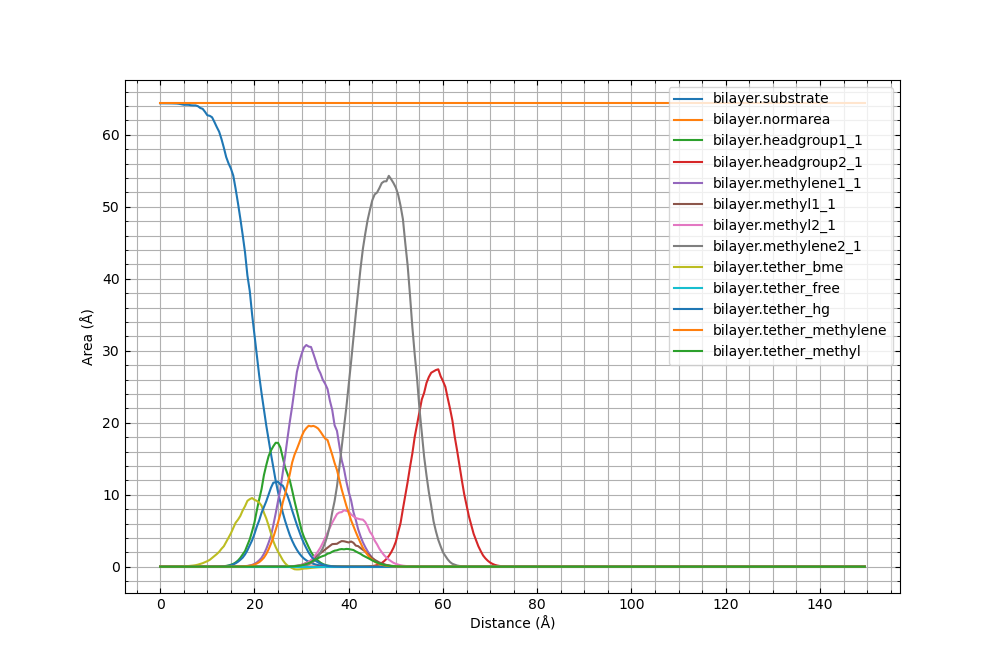

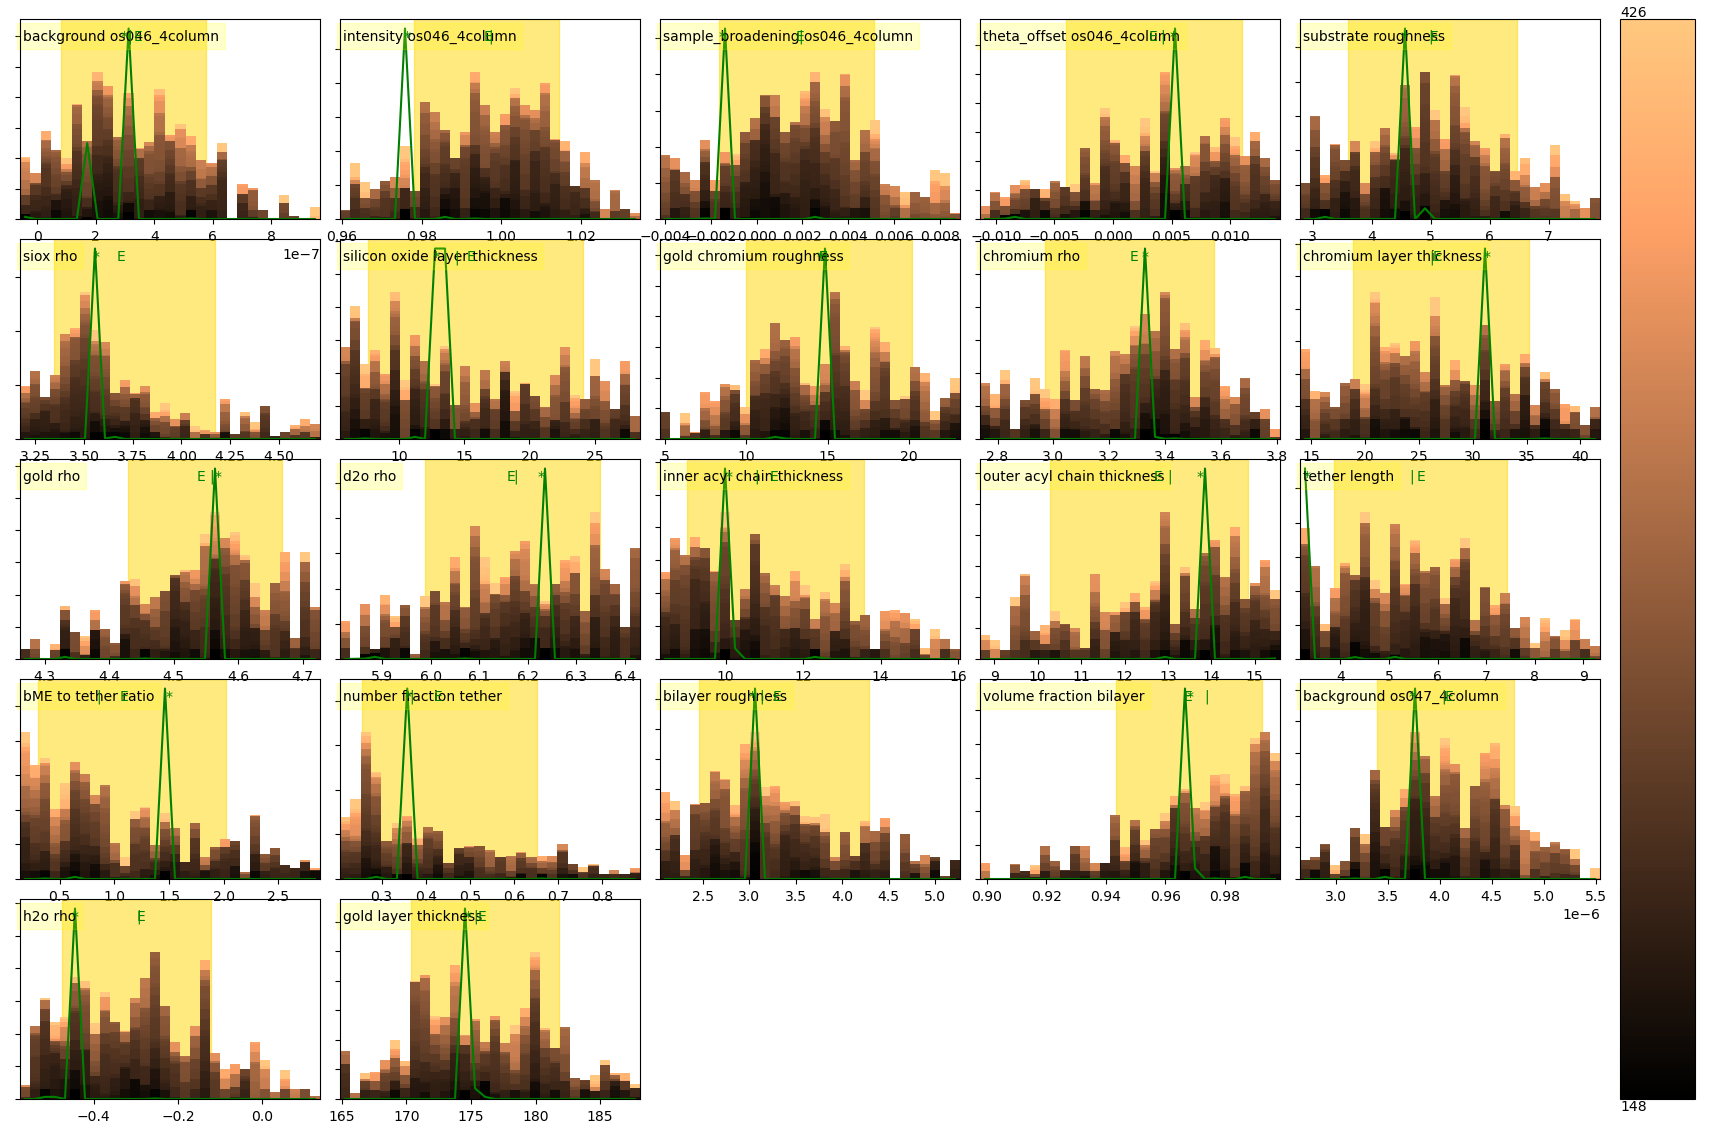

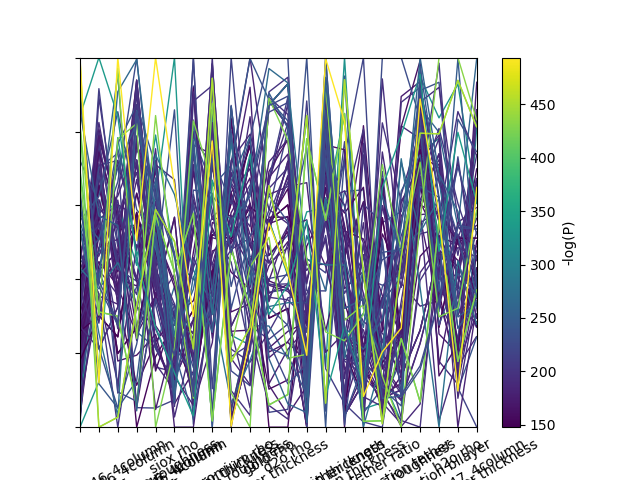

In [8]:
from IPython.display import Image, display
import glob
for file in glob.glob(store+"/*.png"):
    display(Image(filename=file))


# Publication-ready graphs

...

# Useful Routines


Create a HC18 / POPC tethered lipid membrane object and manually change model parameters. Show the molecular
distributions.

Load the best-fit tBLM profile and show it.

In [9]:
model = load_model(runfile+'.py')
load_best(model, store+'/'+runfile+'.par')
model.chisq_str()

'1.26(10)'